# ST446 Distributed Computing for Big Data

## Week 05 class: Stack Exchange Data Analysis

### LT 2020
---

![stack exchange](https://cdn.sstatic.net/Sites/stackoverflow/company/img/logos/se/se-logo.svg?v=d29f0785ebb7)

Stack Exchange (https://stackexchange.com/) is a network of question-and-answer (Q&A) websites on topics in varied fields, each site covering a specific topic: https://stackoverflow.com. 
All sites in the network are modelled after the initial site Stack Overflow, a Q&A site for computer programming questions.

An anonymized dump of all user-contributed content on the Stack Exchange network is available from https://archive.org/details/stackexchange. Each site is formatted as a separate archive consisting of XML files (zipped via 7-zip using bzip2 compression). Each site archive includes Posts, Users, Tags, Votes, Comments, PostHistory and PostLinks. 

In this notebook, we analyze user-contributions in Stack Exchange using Spark graphframes package and the associated API. 
We will first import the data into Spark GraphFrames and then analyze and visualize various graph properties using GraphFrames API.

## Preliminaries

This notebook uses two packages: [spark-xml](https://github.com/databricks/spark-xml) (for importing data from xml files) and [graphframes](https://graphframes.github.io/) (for working with Spark GraphFrames). 

We strongly recommend to include the packages in the dataproc cluster initialisation (when you set up the cluster) like so:

 ```
 gcloud dataproc clusters create jialin-cluster --project st446-lent \
  --properties=^#^spark:spark.jars.packages=graphframes:graphframes:0.5.0-spark2.1-s_2.11,com.databricks:spark-xml_2.11:0.4.1 \
  --subnet default --zone europe-west2-a --master-machine-type n1-standard-4 --master-boot-disk-size 500 --num-workers 2 --worker-machine-type n1-standard-4 --worker-boot-disk-size 500 --image-version 1.3-deb9 \
  --initialization-actions 'gs://dataproc-initialization-actions/jupyter/jupyter.sh','gs://dataproc-initialization-actions/python/pip-install.sh','gs://dataproc-initialization-actions/zookeeper/zookeeper.sh','gs://dataproc-initialization-actions/kafka/kafka.sh' \
  --metadata 'PIP_PACKAGES=sklearn nltk pandas graphframes'
```

Then, choose option 1).

You can use these two packages in PySpark in one of the following ways:

1) Run the code block here:

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.4.0-spark2.0-s_2.11,com.databricks:spark-xml_2.11:0.4.1 pyspark-shell'

If you use your own machine, these options might be useful.

2) Add the GraphFrames package information to the Spark config file: add 
```
spark.jars.packages com.databricks:spark-xml_2.11:0.4.1,graphframes:graphframes:0.3.0-spark2.0-s_2.11
``` 
to 
```
$SPARK_HOME/conf/spark-defaults.conf 
```
and then run the `pyspark` in a command line interface.
    
3) Add the package information as the option argument when running PySpark from a command line interface: run 
```
pyspark --packages com.databricks:spark-xml_2.11:0.4.1,graphframes:graphframes:0.3.0-spark2.0-s_2.11
```

### Load libraries

Run the following code to import the required libraries.

In [2]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

import graphframes
from graphframes import *
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql.functions import col, lit, when
from pyspark.sql import Row

from datetime import datetime

import re
import numpy as np

sc.setCheckpointDir("gs://jialin-bucket/tmp/") # change where to store if you want to

## Loading data from XML files

Please download the required xml files from here (and put them into your bucket): https://www.dropbox.com/sh/89xbpcjl4oq0j4w/AAA4_cGYM5TqB3dkczIQ0qQJa/StackExchange?dl=0

Please change the name `PostLinks` to `Postlinks` to be able to use the code below. I put them into `gs://jialin-bucket/stackexchange/`.

In [5]:
# make sure you have downloaded the data in a bucket and change _fpath_ to the location of the data
fpath = 'gs://jialin-bucket/stackexchange/'

def load_xml(table_name):
    xml_name = table_name.capitalize()
    table = sqlContext.read.format('com.databricks.spark.xml').options(rowTag=table_name).load(fpath+xml_name+'.xml')
    rdd_table = table.rdd.flatMap(lambda x: x).flatMap(lambda x: x)
    df = sqlContext.createDataFrame(rdd_table, table.schema.fields[0].dataType.elementType)
    df.createOrReplaceTempView(table_name)
    return df

In [6]:
users = load_xml("users")  # information about users, such as their reputation, name, access data, down votes, etc....
posts = load_xml("posts")  # contains the text (body) of posts, whether they are questions or answers, how they relate to users and answers
postlinks = load_xml("postlinks") # links
comments = load_xml("comments")
tags = load_xml("tags")

# Understanding the data
Have a look at the structure of posts, ansers and comments: 
https://worldbuilding.stackexchange.com/questions/138559/how-to-prevent-superluminal-traveling-idiots-from-wrecking-half-of-the-universe

Understanding users is pretty straightforward:

In [7]:
# schema of the dataframe
print(type(users))
users.printSchema()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- _AboutMe: string (nullable = true)
 |-- _AccountId: long (nullable = true)
 |-- _Age: long (nullable = true)
 |-- _CreationDate: string (nullable = true)
 |-- _DisplayName: string (nullable = true)
 |-- _DownVotes: long (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _LastAccessDate: string (nullable = true)
 |-- _Location: string (nullable = true)
 |-- _ProfileImageUrl: string (nullable = true)
 |-- _Reputation: long (nullable = true)
 |-- _UpVotes: long (nullable = true)
 |-- _VALUE: string (nullable = true)
 |-- _Views: long (nullable = true)
 |-- _WebsiteUrl: string (nullable = true)



Posts are relatively complex, they can be of two types:
- `Id`
- `PostTypeId`
      - 1: Question
      - 2: Answer
- `ParentID` (only present if `PostTypeId` is 2, i.e. only answers have parents)
- `AcceptedAnswerId` (only present if `PostTypeId` is 1, i.e. only questions may have accepted answers)

Posts have owners (typically the user who asked a question or wrote an answer) and editors (users who edit posts).

In [8]:
posts.printSchema()

root
 |-- _AcceptedAnswerId: long (nullable = true)
 |-- _AnswerCount: long (nullable = true)
 |-- _Body: string (nullable = true)
 |-- _ClosedDate: string (nullable = true)
 |-- _CommentCount: long (nullable = true)
 |-- _CommunityOwnedDate: string (nullable = true)
 |-- _CreationDate: string (nullable = true)
 |-- _FavoriteCount: long (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _LastActivityDate: string (nullable = true)
 |-- _LastEditDate: string (nullable = true)
 |-- _LastEditorDisplayName: string (nullable = true)
 |-- _LastEditorUserId: long (nullable = true)
 |-- _OwnerDisplayName: string (nullable = true)
 |-- _OwnerUserId: long (nullable = true)
 |-- _ParentId: long (nullable = true)
 |-- _PostTypeId: long (nullable = true)
 |-- _Score: long (nullable = true)
 |-- _Tags: string (nullable = true)
 |-- _Title: string (nullable = true)
 |-- _VALUE: string (nullable = true)
 |-- _ViewCount: long (nullable = true)



Post links connect two posts (answers or questions).  They can be of either of two types:
- `PostLinkTypeId`
       - 1: Linked (the question is related to another question)
       - 3: Duplicate (somebody has decided that the question has been asked before)

In [9]:
postlinks.printSchema()

root
 |-- _CreationDate: string (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _LinkTypeId: long (nullable = true)
 |-- _PostId: long (nullable = true)
 |-- _RelatedPostId: long (nullable = true)
 |-- _VALUE: string (nullable = true)



Tags are referenced by posts. They have a name and some additional data, for example:

`<row Id="23" TagName="apache-hadoop" Count="80" ExcerptPostId="5840" WikiPostId="5839" />`

In [10]:
tags.printSchema()

root
 |-- _Count: long (nullable = true)
 |-- _ExcerptPostId: long (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _TagName: string (nullable = true)
 |-- _VALUE: string (nullable = true)
 |-- _WikiPostId: long (nullable = true)



Comments are made by a user and are connected to a post (users can comment on answers and questions).

In [11]:
comments.printSchema()

root
 |-- _CreationDate: string (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _PostId: long (nullable = true)
 |-- _Score: long (nullable = true)
 |-- _Text: string (nullable = true)
 |-- _UserDisplayName: string (nullable = true)
 |-- _UserId: long (nullable = true)
 |-- _VALUE: string (nullable = true)



In [12]:
# total number of posts
posts.count()

11390

In [13]:
# have a look at one of the posts
posts.take(1)

[Row(_AcceptedAnswerId=None, _AnswerCount=1, _Body='<p>I\'ve always been interested in machine learning, but I can\'t figure out one thing about starting out with a simple "Hello World" example - how can I avoid hard-coding behavior?</p>\n\n<p>For example, if I wanted to "teach" a bot how to avoid randomly placed obstacles, I couldn\'t just use relative motion, because the obstacles move around, but I don\'t want to hard code, say, distance, because that ruins the whole point of machine learning.</p>\n\n<p>Obviously, randomly generating code would be impractical, so how could I do this?</p>\n', _ClosedDate='2014-05-14T14:40:25.950', _CommentCount=1, _CommunityOwnedDate=None, _CreationDate='2014-05-13T23:58:30.457', _FavoriteCount=1, _Id=5, _LastActivityDate='2014-05-14T00:36:31.077', _LastEditDate=None, _LastEditorDisplayName=None, _LastEditorUserId=None, _OwnerDisplayName=None, _OwnerUserId=5, _ParentId=None, _PostTypeId=1, _Score=7, _Tags='<machine-learning>', _Title='How can I do si

## Graph analysis 

## 1. Graph of post references

In Stack Exchange, each post may reference other posts through links. For example, pointing the user who posted a question to one or more other posts that addressed his or her question. We are now going to study the graph defined by post references.  

### a. Building the graph

We are going to create a GraphFrame that consists of a _vertices_ dataframe containing information about vertices (posts) and an _edges_ dataframe containing information about edges (links). 

We are going to 
* set the vertice column to  **id** in the vertices DataFrame
* set the begin and end edge columns to **src** and **dst** for the edges DataFrame

We are creating a _directed graph_, as links point from a vertex **src** to another vertex **dst**.

In [14]:
postsVertices = posts.withColumnRenamed("_Id","id").withColumnRenamed("_PostTypeId","PostTypeID").select("id","PostTypeID").distinct()
postsEdges = postlinks.withColumnRenamed("_PostId","src").withColumnRenamed("_RelatedPostId","dst").select("src","dst")
postsGraph = GraphFrame(postsVertices,postsEdges)

In [15]:
postsVertices.show(5)
postsEdges.show(5)

+----+----------+
|  id|PostTypeID|
+----+----------+
| 276|         2|
| 826|         2|
| 908|         2|
|5064|         1|
|5778|         2|
+----+----------+
only showing top 5 rows

+---+---+
|src|dst|
+---+---+
| 14|  1|
| 75| 71|
| 59| 41|
|361| 61|
| 61|361|
+---+---+
only showing top 5 rows



In [16]:
print(postsGraph)

GraphFrame(v:[id: bigint, PostTypeID: bigint], e:[src: bigint, dst: bigint])


### b. Queries 

### i. Simple queries

#### Count the number of posts and links

In [17]:
print("Posts: ", postsGraph.vertices.count())
print("References: ", postsGraph.edges.count())
print("Distinct references: ", postsGraph.edges.distinct().count())

Posts:  11390
References:  369
Distinct references:  346


There are not many links between posts in general!

#### Count the number of posts related to machine learning topic

In [18]:
print("Number of posts related to machine learning:", postsGraph.vertices.filter("_Tags = '<machine-learning>'").count())

Number of posts related to machine learning: 97


#### Count the number of Questions and Answers

In [19]:
print("Number of Questions:", postsGraph.vertices.filter("_PostTypeId = 1").count())
print("Number of Answers:", postsGraph.vertices.filter("_PostTypeId = 2").count())

Number of Questions: 4950
Number of Answers: 6216


#### Posts with the highest number of references to other posts

In [20]:
postsGraph.edges.groupBy("src").count().sort("count", ascending = False).show(5)

+----+-----+
| src|count|
+----+-----+
|5826|    8|
|8646|    5|
|9580|    4|
|2346|    4|
|9677|    4|
+----+-----+
only showing top 5 rows



Note that this corresponds to the outdegree of nodes. The post with the highest number of links pointing to posts only contains 8 links. 

#### How are answers and questions linked?

We use some simple motif queries. Harder ones will be explained later.

How many answers point to questions?

In [21]:
allLinksMotif = postsGraph.find("(a)-[e]->(b)")
print("edges found:", allLinksMotif.count())
print("Answers pointing to other posts:", allLinksMotif.filter("a.PostTypeID = 2").count())

edges found: 317
Answers pointing to other posts: 0


How many questions point to questions?

In [22]:
allLinksMotif.filter("a.PostTypeID = 1 and b.PostTypeID = 1").count()

317

How many questions point to answers?

In [23]:
allLinksMotif.filter("a.PostTypeID = 1 and b.PostTypeID = 2").count()

0

It turns out that in this data set links have always been assigned to question. Even if links are part of an answer, they are assigned to the corresponding question

Where does the discrepancy between the number of edges found here and earlier come from? - It seems like there are "dangling edges". This seems to be a problem with the data a set:

In [24]:
postsGraph.find("()-[e]->()").count()

369

In [25]:
postsGraph.find("(a)-[e]->()").count() # this seems to be the culprit!

325

In [26]:
postsGraph.find("()-[e]->(a)").count()

369

There only seem to be links between questions.

### ii. Vertex degrees

Let us now analyze postsGraph to gain some understanding about the incoming and outcoming references of posts.

* `inDegree`: number of references _to_ the post
* `outDegree`: number of references _from_ the post 
* `degree`: total number of references either _to_ or _from_ the post

#### Degrees:

In [27]:
postsGraph.degrees.sort("Degree", ascending=False).show(5)

+----+------+
|  id|degree|
+----+------+
|5826|     8|
| 739|     8|
|  22|     7|
|1107|     6|
| 155|     6|
+----+------+
only showing top 5 rows



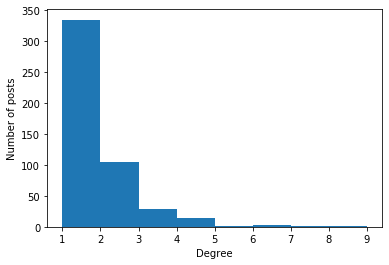

In [28]:
plt.hist(postsGraph.degrees.select("degree").rdd.flatMap(lambda x: x).collect(), bins=range(1,10));
plt.ylabel('Number of posts')
plt.xlabel('Degree');

#### inDegrees

In [29]:
postsGraph.degrees.filter("Degree = 1").count()

335

In [30]:
postsGraph.inDegrees.sort("inDegree", ascending=False).show(5)

+----+--------+
|  id|inDegree|
+----+--------+
| 739|       8|
|  22|       7|
| 155|       6|
|1107|       5|
| 758|       5|
+----+--------+
only showing top 5 rows



In [31]:
# what is the post with the high in-degree?
print(posts.select("_PostTypeID").where("_Id == 739").collect())
print(posts.select("_Body").where("_Id == 739").collect())

[Row(_PostTypeID=1)]
[Row(_Body='<p>I am an MSc student at the University of Edinburgh, specialized in machine learning and natural language processing. I had some practical courses focused on data mining, and others dealing with machine learning, bayesian statistics and graphical models. My background is a BSc in Computer Science.</p>\n\n<p>I did some software engineering and I learnt the basic concepts, such as design patterns, but I have never been involved in a large software development project. However, I had a data mining project in my MSc. My question is, if I want to go for a career as Data Scientist, should I apply for a graduate data scientist position first, or should I get a position as graduate software engineer first, maybe something related to data science, such as big data infrastructure or machine learning software development?</p>\n\n<p>My concern is that I might need good software engineering skills for data science, and I am not sure if these can be obtained by wor

#### outDegrees

In [32]:
postsGraph.outDegrees.sort("outDegree", ascending=False).show(5)

+----+---------+
|  id|outDegree|
+----+---------+
|5826|        8|
|8646|        5|
|9580|        4|
|2346|        4|
|9677|        4|
+----+---------+
only showing top 5 rows



Let us check the content of the post that has the largest outdegree:

In [33]:
print(posts.select("_PostTypeID").where("_Id == 5826").collect())
print(posts.select("_Body").where("_Id == 5826").collect())

[Row(_PostTypeID=1)]
[Row(_Body='<p>I am looking to change careers and would appreciate some advice. </p>\n\n<p>I have an undergraduate degree in English Literature and a JD. Needless to say, these were not the best decisions and I would like to change my career. I have always enjoyed math and science, and after months of research and self study, I have decided that I would like to pursue statistics. </p>\n\n<p>My question is basically this : would it be better to get another Bach. Degree in statistics or should I take calculus 1-3, linear algebra, probably and statistics and some computer science courses at a community college then try to get into a grad program instead? </p>\n\n<p>I am afraid that without the bachelors degree I will not have the required knowledge for a masters even after taking the courses at my local c.c. However, another bachelors degree may be a worthless waste of time. </p>\n\n<p>Please share your thoughts. Also, sorry if this is not the right place for this que

You may find out more information about this post here https://datascience.stackexchange.com/questions/5826/master-degree-in-data-science.

In [34]:
# answers have no out- or in-degree
print(postsGraph.find("(a)-[e]->()").filter("a.PostTypeID = 2").count())
print(postsGraph.find("()-[e]->(a)").filter("a.PostTypeID = 2").count())

0
0


### iii. Ranking posts using PageRank scores

We estimate approximate PageRank scores of posts by running the iterative PageRank algorithm for a specified number of iterations.

The `resetProbability` in this particular algorithm is the probability with which a random walker starts at a uniformly chosen new point in the graph (https://arxiv.org/abs/1208.3071). This allows it to deal with disconnected components.

In [35]:
# Determining ranking scores of posts using PageRank
# note that this is not the normalised version of page-rank.
ranks = postsGraph.pageRank(resetProbability=0.15, maxIter=5)
ranks.vertices.orderBy(ranks.vertices.pagerank.desc()).limit(10).show()

+-----+----------+------------------+
|   id|PostTypeID|          pagerank|
+-----+----------+------------------+
|  361|         1|10.763095393978398|
|   61|         1| 7.678784071610369|
| 2651|         1|7.5179330181755875|
|  739|         1| 7.113671904823985|
|17298|         1| 6.470834900206587|
|13484|         1| 6.470834900206587|
|13574|         1| 6.470834900206587|
|  955|         1| 6.470834900206587|
|  954|         1| 6.470834900206587|
| 9612|         1| 6.470834900206587|
+-----+----------+------------------+



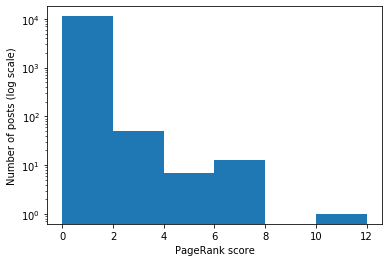

In [36]:
plt.hist(ranks.vertices.orderBy("pagerank").select("pagerank").rdd.flatMap(lambda x: x).collect(), bins=(0,2,4,6,8,10,12));
plt.ylabel('Number of posts (log scale)')
plt.xlabel('PageRank score');
plt.yscale('log')

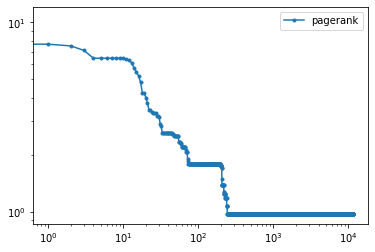

In [37]:
rankDF = ranks.vertices.orderBy(ranks.vertices.pagerank.desc()).select("pagerank")
rankDF = rankDF.toPandas().replace(0,np.nan) # get rid of zeros for loglog plot
rankDF.plot(loglog=True, marker='.')

### iv. Motif finding queries

Motif queries allow us to query subgraphs (e.g. a path) of the input graph by specifying conditions on the graph structure and properties of vertices and edges. 

Here is an example of a motif query that asks for **all possible paths** of length two whose non-terminal vertex (not a source or a destination) is node 8646:

In [38]:
link_of_ref = postsGraph.find("(a)-[ab]->(b); (b)-[bc]->(c)").filter("b.id = 8646")

In [39]:
link_of_ref.show()

+---------+------------+---------+------------+---------+
|        a|          ab|        b|          bc|        c|
+---------+------------+---------+------------+---------+
|[8820, 1]|[8820, 8646]|[8646, 1]| [8646, 736]| [736, 1]|
|[8820, 1]|[8820, 8646]|[8646, 1]|[8646, 6939]|[6939, 1]|
|[8820, 1]|[8820, 8646]|[8646, 1]| [8646, 454]| [454, 1]|
|[8820, 1]|[8820, 8646]|[8646, 1]|[8646, 1107]|[1107, 1]|
|[8820, 1]|[8820, 8646]|[8646, 1]| [8646, 810]| [810, 1]|
+---------+------------+---------+------------+---------+



We have found all possible paths of length 2 with b in the middle.

### v. Connected components

Finding connected components of a graph is a basic graph processing problem. Here is how we can find connected components of postsGraph and visualize their size distribusion.

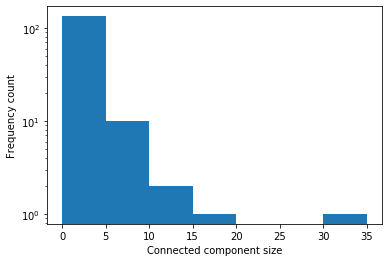

In [65]:
postsComponents = postsGraph.connectedComponents() # only consider connected components

# calculate the number of nodes in each "cluster" and show the result in a histogram
plt.hist(postsComponents.select("id", "component").groupBy("component").count().select("count").where("count != 1")
         .rdd.flatMap(lambda x: x).collect(), bins=range(0,40,5)); 
plt.ylabel('Frequency count')
plt.xlabel('Connected component size')
plt.yscale('log')

# put plot of values, as before, not histogram

## 2. Graph of user co-contributions

We now consider the graph where vertices correspond to users and edges indicate their co-contributions to posts. In particular, we define the graph such that there is an edge between two vertices, if the corresponding users both contributed to at least one common post (either by submitting the post or a comment to this post).

In [43]:
usersVertices = users.withColumnRenamed("_Id","id").select("id").distinct()
usersEdges = sqlContext.sql("select u._Id as dst, c._UserId as src from (users u join posts p on u._Id = p._OwnerUserId) join comments c on p._Id = c._PostId")

usersGraph = GraphFrame(usersVertices,usersEdges)

Do the same type of basic analysis for usersGraph, as we did earlier for postsGraph:

In [44]:
## your code

## 3. Bipartite graph: users-posts

We now examine user contributions across different posts by considering the bipartite graph that describes user contributions across different posts. 

Recall that a bipartite graph is a graph where the set of vertices are partitioned in two disjoint sets (referred as left and right) such that each edge of the graph connects two vertices in different set. 

## a. Create the graph

We create the bipartite graph with the left vertices representing users and the right vertices representing posts. 

An edge from vertex $u$ to vertex $p$ exists if, and only if, (a) user $u$ is the owner of post $p$ or (b) user $u$ commented on post $p$.

In [45]:
# "U" is the prefix for user id and "P" is the prefix for post id to make the vertex ids unique

usersVerticesWithType = usersVertices.rdd.map(lambda r: Row(id="U"+str(r.id), vtype="user")).toDF()
postsVerticesWithType = postsVertices.rdd.map(lambda r: Row(id="P"+str(r.id), vtype="post")).toDF()

commentsEdges = comments.select("_UserId","_PostId").rdd.map(lambda r: Row(src="U"+str(r._UserId),dst="P"+str(r._PostId))).toDF()
postsEdges = posts.select("_OwnerUserId","_Id").rdd.map(lambda r: Row(src="U"+str(r._OwnerUserId),dst="P"+str(r._Id))).toDF()

bipartiteVertices = usersVerticesWithType.unionAll(postsVerticesWithType)
bipartiteEdges = commentsEdges.unionAll(postsEdges)

bipartiteGraph = GraphFrame(bipartiteVertices,bipartiteEdges)

In [46]:
bipartiteGraph.vertices.filter("vtype='user'").show(5)
bipartiteGraph.vertices.filter("vtype='post'").show(5)

+-----+-----+
|   id|vtype|
+-----+-----+
|  U26| user|
|  U29| user|
| U474| user|
| U964| user|
|U2509| user|
+-----+-----+
only showing top 5 rows

+-----+-----+
|   id|vtype|
+-----+-----+
| P276| post|
| P826| post|
| P908| post|
|P5064| post|
|P5778| post|
+-----+-----+
only showing top 5 rows



## b. Queries

### i. Top 5 most contributing users

We can identify a set of top 5 users who made the largest number of contributions by identifying a set of five users with largest outdegrees.

In [47]:
# usersOutDegrees = bipartiteGraph.outDegrees.filter("SUBSTRING(id, 1, 1) = 'U'")
usersOutDegrees = bipartiteGraph.outDegrees #only users have out dedrees!
usersOutDegrees.sort("outDegree", ascending=False).show(5)

+------+---------+
|    id|outDegree|
+------+---------+
|  U381|      703|
|  U836|      575|
|U11097|      460|
|   U21|      355|
|  U471|      351|
+------+---------+
only showing top 5 rows



Let us check the user who has made the largest number of contributions.

In [48]:
users.where("_Id = 381").select("_DisplayName").show()
users.where("_Id == 381").collect()

+------------+
|_DisplayName|
+------------+
|        Emre|
+------------+



[Row(_AboutMe="<p>I don't usually have the time or inclination to write long answers, so I try to point people in the right direction with a comment. I am a professional data scientist, and I write production code.</p>\n", _AccountId=441850, _Age=None, _CreationDate='2014-06-08T06:51:59.140', _DisplayName='Emre', _DownVotes=18, _Id=381, _LastAccessDate='2017-03-13T20:13:31.720', _Location='Silicon Valley', _ProfileImageUrl='https://www.gravatar.com/avatar/4b0380e2f3955f88f8fda269dfcfcf97?s=128&d=identicon&r=PG', _Reputation=5709, _UpVotes=555, _VALUE=None, _Views=212, _WebsiteUrl='')]

### ii. Distribution of the number of contributions per user

We plot the complementary CDF of the number of contributions per user in the log-log scale. The shape of this distibution suggests a power-law tail which is often found in nature.

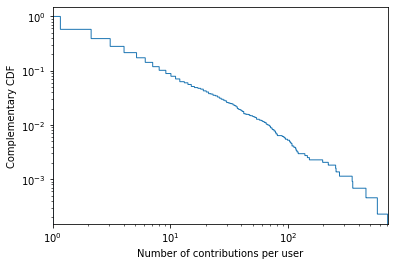

In [49]:
user_contribution = usersOutDegrees.select("outDegree").rdd.flatMap(lambda x: x).collect()
plt.hist(user_contribution, bins=len(user_contribution), density=1, histtype='step', cumulative=-1)

plt.xlabel('Number of contributions per user')
plt.ylabel('Complementary CDF')
plt.xlim([min(user_contribution),max(user_contribution)])
plt.yscale('log')
plt.xscale('log')
plt.show()

### iii. The top 5 most answered posts

We can identify a set of top 5 most answered posts by selecting a set of five nodes with the largest indegree. 

In [50]:
bipartiteGraph.inDegrees.sort("inDegree", ascending=False).limit(5).show()

+------+--------+
|    id|inDegree|
+------+--------+
|P12186|      20|
| P5178|      19|
|P13430|      18|
|  P411|      18|
|P13514|      16|
+------+--------+



Let us now check the post that received the largest number of answers.

In [51]:
posts.select("_Body").where("_Id == 12186").collect()

[Row(_Body='<p>I have a large set of points (order of 10k points) formed by particle tracks (movement in the xy plane in time filmed by a camera, so 3d - 256x256px and ca 3k frames in my example set) and noise. These particles travel on approximately straight lines roughly (but only roughly) in the same direction, and so for the analysis of their trajectories I am trying to fit lines through the points. I tried to use Sequential RANSAC, but can\'t find a criterion to reliably single out false positives, as well as T- and J-Linkage, which were too slow and also not reliable enough.</p>\n\n<p>Here is an image of a part of the dataset with good and bad fits I got with sequential Ransac: <a href="https://i.stack.imgur.com/8ua2o.png" rel="nofollow noreferrer"><img src="https://i.stack.imgur.com/8ua2o.png" alt="enter image description here"></a>\nI\'m using the centroids of the particle blobs here, blob sizes vary between 1 and about 20 pixels.</p>\n\n<p>I found that subsamples using for exa

### iv. Average number of contributions per user 

In [52]:
avg_contribution = bipartiteGraph.edges.count()/bipartiteGraph.edges.distinct().count()
print("The average contribution per user that has contributed at least once is %.2f." % avg_contribution)

The average contribution per user that has contributed at least once is 1.34.


## 4. Tripartite graph: users-posts-tags

We now consider the tripartite graph that has three disjoint sets of vertices of the following respective types: users, posts, and tags. Tags are keywords associated with posts. 

## a. Creating the graph

The edges of the graph are defined as follows:
 
* Edge from $u$ to $p$: if user $u$ is the owner of post $p$ or $u$ has commented on post $p$
* Edge from $p$ to $t$: if post $p$ has tag $t$

We use regular expressions to extract tags from the string _Tags_.

In [53]:
tagsVerticesWithType = tags.select("_TagName").distinct().rdd.map(lambda r: Row(id=str(r._TagName), vtype="tag")).toDF()
tags_regex = re.compile(r"<\w*>")
tagsEdges = posts.select("_Id","_Tags").dropna().rdd.flatMap(lambda r: [Row(src="P"+str(r._Id),dst=tag.replace('>','').replace('<','')) for tag in tags_regex.findall(r._Tags)]).toDF()

tripartiteVertices = bipartiteVertices.unionAll(tagsVerticesWithType)
tripartiteEdges = bipartiteEdges.unionAll(tagsEdges)

tripartiteGraph = GraphFrame(tripartiteVertices,tripartiteEdges)

In [54]:
tripartiteGraph.vertices.filter("vtype='tag'").show(5)
tripartiteGraph.vertices.filter("vtype='user'").show(5)
tripartiteGraph.vertices.filter("vtype='post'").show(5)
tripartiteGraph.edges.show(5)

+------------------+-----+
|                id|vtype|
+------------------+-----+
|            graphs|  tag|
|feature-extraction|  tag|
| ensemble-modeling|  tag|
|            theano|  tag|
|        evaluation|  tag|
+------------------+-----+
only showing top 5 rows

+-----+-----+
|   id|vtype|
+-----+-----+
|  U26| user|
|  U29| user|
| U474| user|
| U964| user|
|U2509| user|
+-----+-----+
only showing top 5 rows

+-----+-----+
|   id|vtype|
+-----+-----+
| P276| post|
| P826| post|
| P908| post|
|P5064| post|
|P5778| post|
+-----+-----+
only showing top 5 rows

+---+---+
|dst|src|
+---+---+
| P5|U34|
| P7|U51|
| P7|U66|
|P15|U51|
|P10|U24|
+---+---+
only showing top 5 rows



## b. Queries

### i. Top 10 most popular topics with respect to the number of posts

We can compute this by counting the number of incident edges to each tag (referred to here as topic).

Text(0.5, 0, 'number of posts')

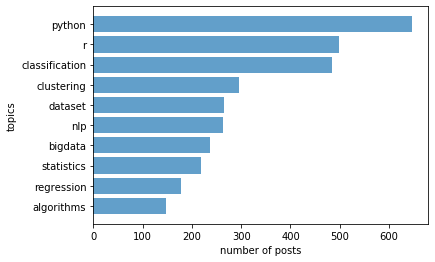

In [55]:
topTen = tripartiteGraph.inDegrees.sort("inDegree",ascending=False).limit(10).collect()

fig, ax = plt.subplots()
ax.barh(range(len(topTen)),[t.inDegree for t in topTen], alpha=0.7)
ax.set_yticks(range(len(topTen)))
ax.set_yticklabels([t.id for t in topTen])
ax.invert_yaxis()
plt.ylabel('topics')
plt.xlabel('number of posts')

### ii. Top 10 most popular topics with respect to the number of user contributions

We now want to compute the popularity of topics with respect to the number of user contributions made to them. We can do this by evaluating motif queries that count the number of distinct paths from user vertices to each given tag vertex. 

In [56]:
# let's look at the graph's structure using one example post:
tripartiteGraph.edges.filter("src='P7'").show()
tripartiteGraph.edges.filter("dst='P7'").show()

+---------+---+
|      dst|src|
+---------+---+
|education| P7|
+---------+---+

+---+----+
|dst| src|
+---+----+
| P7| U51|
| P7| U66|
| P7| U36|
| P7|U158|
| P7| U36|
+---+----+



In [57]:
tripartiteGraph.edges.filter("dst='education'").show(5)

+---------+----+
|      dst| src|
+---------+----+
|education|  P7|
|education|P159|
|education|P289|
|education|P334|
|education|P370|
+---------+----+
only showing top 5 rows



In [58]:
# this is an exampe of what kind of structures we want to count:
tripartiteGraph.find("(c)-[]->(a);(a)-[]->(b)").filter("b.id='education'").show(5)

+--------------+--------------+----------------+
|             c|             a|               b|
+--------------+--------------+----------------+
|  [U839, user]|  [P370, post]|[education, tag]|
|  [U615, user]|  [P289, post]|[education, tag]|
|  [U560, user]|  [P289, post]|[education, tag]|
|[U26090, user]|[P15094, post]|[education, tag]|
|[U21573, user]|[P12850, post]|[education, tag]|
+--------------+--------------+----------------+
only showing top 5 rows



root
 |-- tags: struct (nullable = false)
 |    |-- id: string (nullable = true)
 |    |-- vtype: string (nullable = true)
 |-- count: long (nullable = false)



Text(0, 0.5, 'Topics')

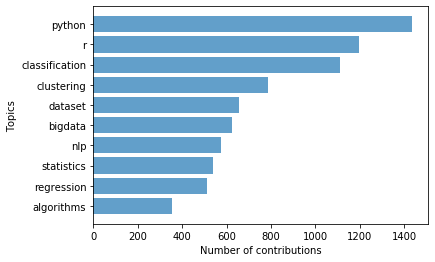

In [59]:
all_edges = tripartiteGraph.find("(users)-[]->(posts); (posts)-[]->(tags)")

tagsActivity = all_edges.select("tags").groupBy('tags').count()
tagsActivity.printSchema()
topTen = tagsActivity.sort("count",ascending=False).withColumnRenamed("count","c").limit(10).collect()

fig, ax = plt.subplots()
ax.barh(range(len(topTen)),[t.c for t in topTen], alpha=0.7)
ax.set_yticks(range(len(topTen)))
ax.set_yticklabels([t.tags.id for t in topTen])
ax.invert_yaxis()
plt.xlabel("Number of contributions")
plt.ylabel("Topics")

This seems quite similar the previous observations on popularity of topics, even though we are looking at quite a different measure.

### iii. Find a user who contributed the most to one specific topic

In [60]:
usersTags = all_edges.select("users","tags").groupBy("users","tags").count()
usersTags.sort("count",ascending=False).limit(10).show()

+-------------+--------------------+-----+
|        users|                tags|count|
+-------------+--------------------+-----+
| [U381, user]|       [python, tag]|   73|
| [U471, user]|            [r, tag]|   61|
| [U924, user]|   [clustering, tag]|   61|
| [U381, user]|   [clustering, tag]|   38|
| [U836, user]|[classification, ...|   35|
| [U381, user]|[classification, ...|   35|
| [U381, user]|      [dataset, tag]|   33|
|  [U21, user]|            [r, tag]|   33|
|[U9793, user]|            [r, tag]|   30|
| [U836, user]|       [python, tag]|   29|
+-------------+--------------------+-----+



### iv. Find users with the largest number of accepted answers to a topic

The users who achieved the largest number of accepted answers for a topic may be regarded as experts on this topic. Here is one way to identify such users:

In [61]:
edges_df = all_edges.rdd.map(lambda r:Row(users=int(r.users.id[1:]),posts=int(r.posts.id[1:]),tags=r.tags)).toDF()
accepted_answers = edges_df.join(posts.withColumnRenamed("_Id","posts"),"posts").join(comments.withColumnRenamed("_Id","_AcceptedAnswerId"),"_AcceptedAnswerId")
accepted_answers_count = accepted_answers.where("users = _UserId").groupBy("users","tags").count().sort("count",ascending=False)

accepted_answers_count.limit(10).show()
#for r in a.take(20):
#    print(posts.where("_Id = '" + r['posts']['id'][1:] + "'").select("_AcceptedAnswerId").withColumnRenamed("_AcceptedAnswerId","_Id").join(comments,"_Id").count())

+-----+--------------------+-----+
|users|                tags|count|
+-----+--------------------+-----+
|16740|[classification, ...|    3|
|15361|       [python, tag]|    2|
| 6478|       [python, tag]|    2|
| 9420|          [svm, tag]|    2|
| 2452|       [python, tag]|    2|
| 6478|         [nltk, tag]|    2|
|17815|      [ranking, tag]|    2|
|15361|          [nlp, tag]|    2|
| 6478|       [gensim, tag]|    2|
| 6478|       [scikit, tag]|    2|
+-----+--------------------+-----+



### v. The number of users that have written accepted answers for different topics

The number of distinct topics for which a user has at least one answer selected as the best answer could be indicative of the user's diversity of skills. We compute the number of users who have answers selected as best answers for a given number of distinct topics as follows.

/opt/conda/lib/python3.7/site-packages/ipykernel/__main__.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  app.launch_new_instance()


Text(0, 0.5, 'Number of users')

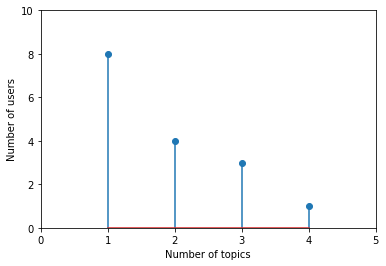

In [62]:
nbTopicsAnswered = accepted_answers_count.groupBy("users").count().withColumnRenamed("count","nb").groupBy("nb").count().withColumnRenamed("count","c").sort("nb").collect()

plt.stem([t.nb for t in nbTopicsAnswered], [t.c for t in nbTopicsAnswered])
plt.xlim([0, 5])
plt.ylim([0, 10])
plt.xlabel('Number of topics')
plt.ylabel('Number of users')

## 5. Temporal graph properties

Here we examine activity of user contributions over time. 

### a. Number of comments submitted per month

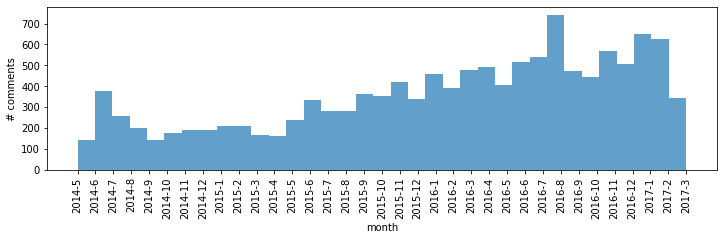

In [63]:
dt = comments.select("_CreationDate").rdd.map(lambda r: datetime.strptime(r._CreationDate, '%Y-%m-%dT%H:%M:%S.%f')).collect()

months = [''.join([str(r.year),'-',str(r.month)])  for r in dt] # this is a bit hacky
fig, ax = plt.subplots(figsize=(12,3))

a, b, c = ax.hist(months,bins=35,histtype='stepfilled', edgecolor='none', alpha=0.7)

ax.set_ylabel('# comments')
ax.set_xlabel('month');
plt.xticks(rotation=90);

We observe a general trend of increasing number of contributions over time.

### b. Number of posts created in different days of a week

Text(0, 0.5, '# comments')

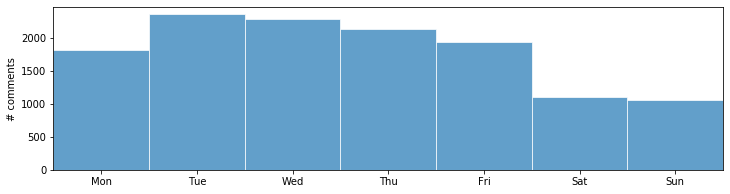

In [64]:
fig, ax = plt.subplots(figsize=(12,3))

ax.hist([x.weekday() for x in dt],bins=[0, 1, 2, 3, 4, 5, 6, 7], edgecolor='w', alpha=0.7)
ax.set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
ax.set_xlim([0,7])
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
ax.set_ylabel('# comments')